In [1]:
import numpy as np
import scipy.stats as sc
import pandas as pd
import matplotlib.pyplot as plt
import folium

In [2]:
review_fields = ['review_id', 'user_id', 'business_id', 'stars', 'date']
review_fields2 = ['user_id', 'business_id', 'stars']
business_fields = ['business_id', 'name', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'categories', 'is_open']
user_fields = ['user_id', 'name', 'review_count', 'yelping_since', 'average_stars']

In [14]:
prefix = ''#"/Users/Dominic/Downloads/"
business_df = pd.read_csv(prefix + "yelp_business.csv", usecols=business_fields)
review_chunks = pd.read_csv(prefix + "yelp_review.csv",usecols=review_fields,chunksize=500000)
users = pd.read_csv(prefix + "yelp_user.csv",usecols=user_fields)
reviews_raw = pd.read_csv(prefix + "yelp_review.csv",usecols=review_fields2)
business_hours = pd.read_csv(prefix + "yelp_business_hours.csv")

In [15]:
class Sampleable:
    def __init__(self, sample):
        self.sample = self.__mutate(sample)
        assert isinstance(self.sample, pd.core.frame.DataFrame)
        self.sample.dropna()
        self.sample_size = 0
            
    def __mutate(self, sample):
        if isinstance(sample, pd.io.parsers.TextFileReader):
            for s in sample: sample = s; break
        return sample
    
    def getType(self):
        return self.type
    
    def getSample(self, n_samples):
        self.sample_size = n_samples
        rows = np.random.choice(self.sample.index.values, n_samples)
        return self.sample.iloc[rows]
    
    def getOrderedSample(self, n_samples):
        return self.sample.head(n_samples)
    
    def randomMutate(self, new_sample):
        self.sample = self.__mutate(new_sample)
    
businessSampler = Sampleable(business_df)
reviewSampler = Sampleable(review_chunks)
userSampler = Sampleable(users)
businessHoursSampler = Sampleable(business_hours)

In [16]:
b_samp = businessSampler.getSample(50000)
h_samp = businessHoursSampler.getSample(50000)

In [110]:
week = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
def remove_none(sample):
    for day in week:
        sample = sample[sample[day] != 'None']
    return sample

def times_to_hours_2(text):
    text = text.split('-')
    if len(text) < 2:
        return 0
    start = text[0].split(':')
    end = text[1].split(':')
    hours = int(end[0]) - int(start[0])
    mins = int(end[1]) - int(start[1])
    return abs(round(float(hours) + (float(mins) / 60.), 1))

def times_to_hours(row):
    sum1 = 0.
    for day in week:
        sum1 = sum1 + times_to_hours_2(row[day])
    return round(sum1 / 7., 2)

def is_late_night(row):
    close = row['friday']
    close = close.split('-')
    if len(close) < 2:
        return False
    close = close[1].split(':')
    return (int(close[0]) > 22) or (int(close[0]) < 3)

In [125]:
sample = remove_none(business_hours)
#sample = remove_none(h_samp)
sample['hours_open'] = sample.apply(times_to_hours, axis = 1)

In [126]:
sample['late_night'] = sample.apply(is_late_night, axis = 1)

In [127]:
sample2 = sample[['business_id', 'hours_open', 'late_night']].join(business_df.set_index('business_id'), on='business_id', lsuffix='_l',rsuffix='_r')
sample2.head()

,business_id,hours_open,late_night,name,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
3,8DShNS-LuFqpEWIp0HxijA,10.57,False,"""Sports Authority""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,10.00,True,"""Brick House Tavern + Tap""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...
7,OD2hnuuTJI9uotcKycxg1A,7.57,False,"""Soccer Zone""",Las Vegas,NV,89128,36.197484,-115.249660,1.5,9,1,Shopping;Sporting Goods
9,TGWhGNusxyMaA4kQVBNeew,9.00,False,"""Detailing Gone Mobile""",Henderson,NV,89014,36.055825,-115.046350,5.0,7,1,Automotive;Auto Detailing
11,Y0eMNa5C-YU1RQOZf9XvVA,7.93,False,"""CubeSmart Self Storage""",Chandler,AZ,85286,33.271720,-111.791257,5.0,23,1,Local Services;Self Storage


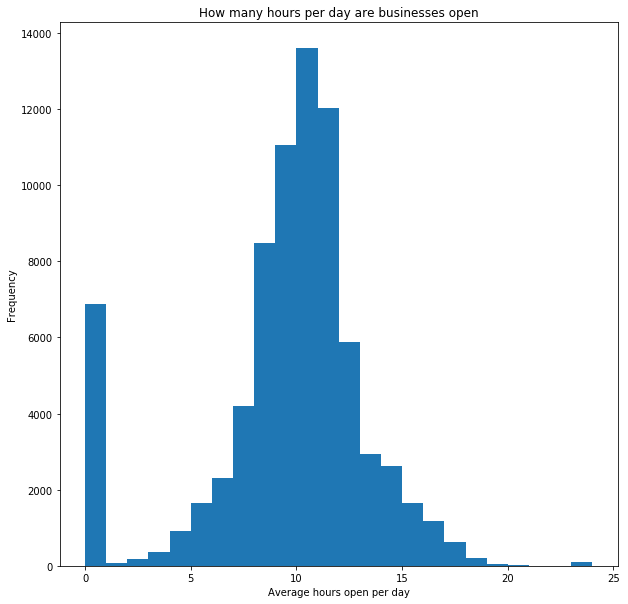

In [128]:
plt.figure(figsize=(10,10))
plt.hist(sample2['hours_open'], range=(0,24), bins=24)
plt.xlabel('Average hours open per day')
plt.ylabel('Frequency')
plt.title('How many hours per day are businesses open')
plt.show()

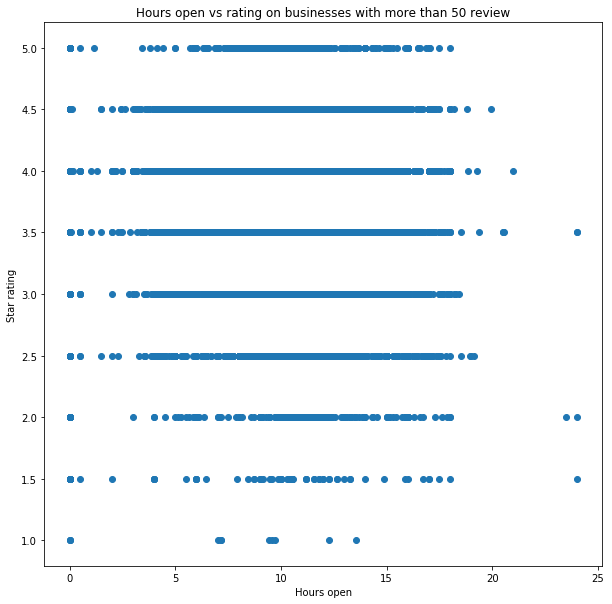

In [129]:
plt.figure(figsize=(10,10))
plt.scatter(sample2[sample2['review_count'] > 50]['hours_open'],sample2[sample2['review_count'] > 50]['stars'])
plt.xlabel('Hours open')
plt.ylabel('Star rating')
plt.title('Hours open vs rating on businesses with more than 50 review')
plt.show()

In [130]:
sample2['hours_open'].corr(sample2['stars'])

-0.026703188528250283

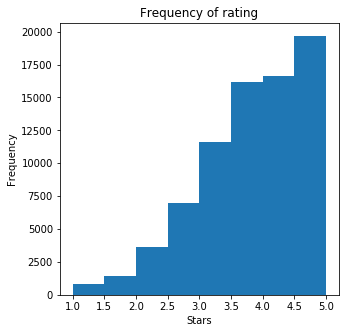

In [131]:
plt.figure(figsize=(5,5))
plt.hist(sample2['stars'], bins=8)
plt.xlabel('Stars')
plt.ylabel('Frequency')
plt.title('Frequency of rating')
plt.show()

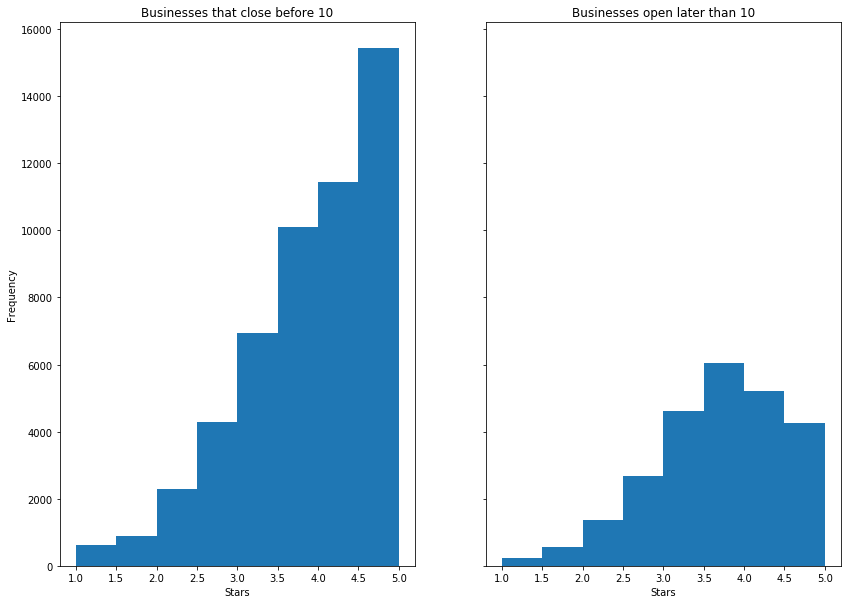

In [132]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(14,10))
axs[0].hist(sample2[sample2['late_night'] == False]['stars'], bins = 8)
axs[1].hist(sample2[sample2['late_night'] == True]['stars'], bins = 8)
#plt.set_xlabel('Stars')
axs[0].set_ylabel('Frequency')
axs[1].set_xlabel('Stars')
axs[0].set_xlabel('Stars')
axs[0].set_title('Businesses that close before 10')
axs[1].set_title('Businesses open later than 10')
plt.show()

In [95]:
focused_sample = b_samp[(b_samp['longitude'] < -50) & (b_samp['latitude'] <= 60) & (b_samp['latitude']>=0)]
len(focused_sample)

47740

In [96]:
def get_map_color(stars):
    if stars >= 4.5:
        return 'green'
    if stars >= 3.5:
        return 'lightgreen'
    if stars >= 2.5:
        return 'red'
    return 'darkred'

In [99]:
m = folium.Map(location=[20, 0], tiles="Mapbox Bright", zoom_start=2)

for index, row in focused_sample.head(100).iterrows():
    s = "{} ({})".format(row['name'].strip("\"").replace("'", ""),row['stars'])
    folium.Marker([row['latitude'], row['longitude']], popup=s, icon=folium.Icon(color=get_map_color(row['stars']))).add_to(m)
m